In [80]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


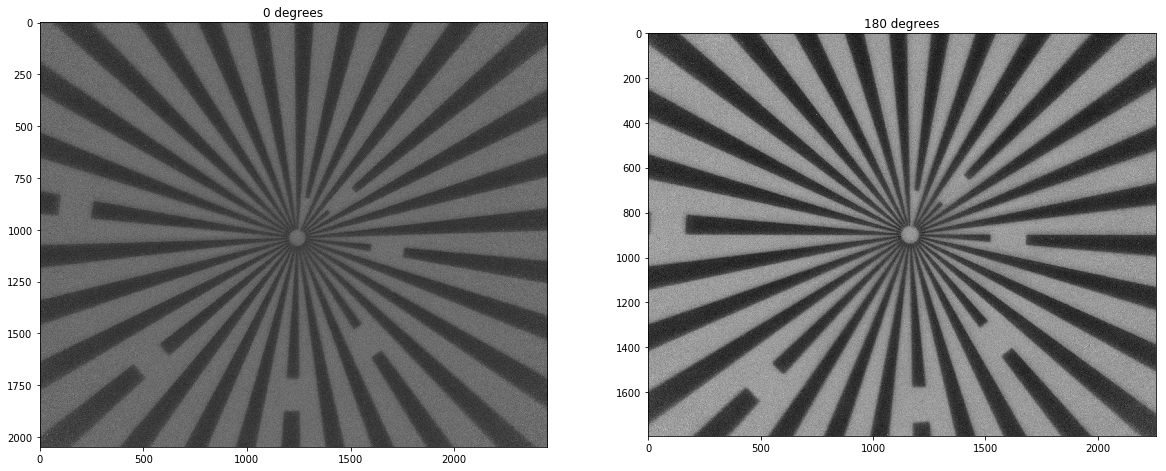

In [93]:
samples = ['./samples/rot_0.tif', 
           './samples/rot_180.tif',
           './samples/faked_rot_0_tilted_5.3deg.tif',
           './samples/faked_rot_180.tif']

img0 = tiff.imread(samples[0])
img180 = tiff.imread(samples[2])
img180 = cv2.flip(img180, 1)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180, cmap='gray')
plt.title("180 degrees")
plt.show()


### Rescale image to speed up processing. Rescale to only 40% of the size. 

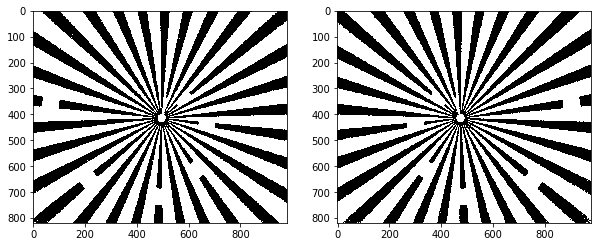

In [16]:
img0_rescaled = rescale(img0, 0.4, mode='reflect')
thresh = threshold_li(img0_rescaled)
binary0 = img0_rescaled > thresh

img180_rescaled = rescale(img180, 0.4, mode='reflect')
thresh = threshold_li(img180_rescaled)
binary180 = img180_rescaled > thresh


f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(binary0, cmap='gray')
ax1.imshow(binary180, cmap='gray')
plt.show()

### Invert Image

The inversion helps to make the black edges part of the foreground instead of background. 

In [17]:
# Create few empty image for processing. 

img0_empty = np.zeros_like(binary0, dtype=np.uint8)
img0_binary = np.zeros_like(binary0, dtype=np.uint8)
img0_binary_inv = np.zeros_like(binary0, dtype=np.uint8)

img0_binary[binary0] = 255
img0_binary_inv[~binary0] = 255

img180_empty = np.zeros_like(binary180, dtype=np.uint8)
img180_binary = np.zeros_like(binary180, dtype=np.uint8)
img180_binary_inv = np.zeros_like(binary180, dtype=np.uint8)

img180_binary[binary180] = 255
img180_binary_inv[~binary180] = 255

### Masking

Mask out the center part of the image. The center region is connecting all the spokes of the star together. This causes problem in identifying each spoke individually. We will mask out the center region to improve detection of each spoke seperately. 

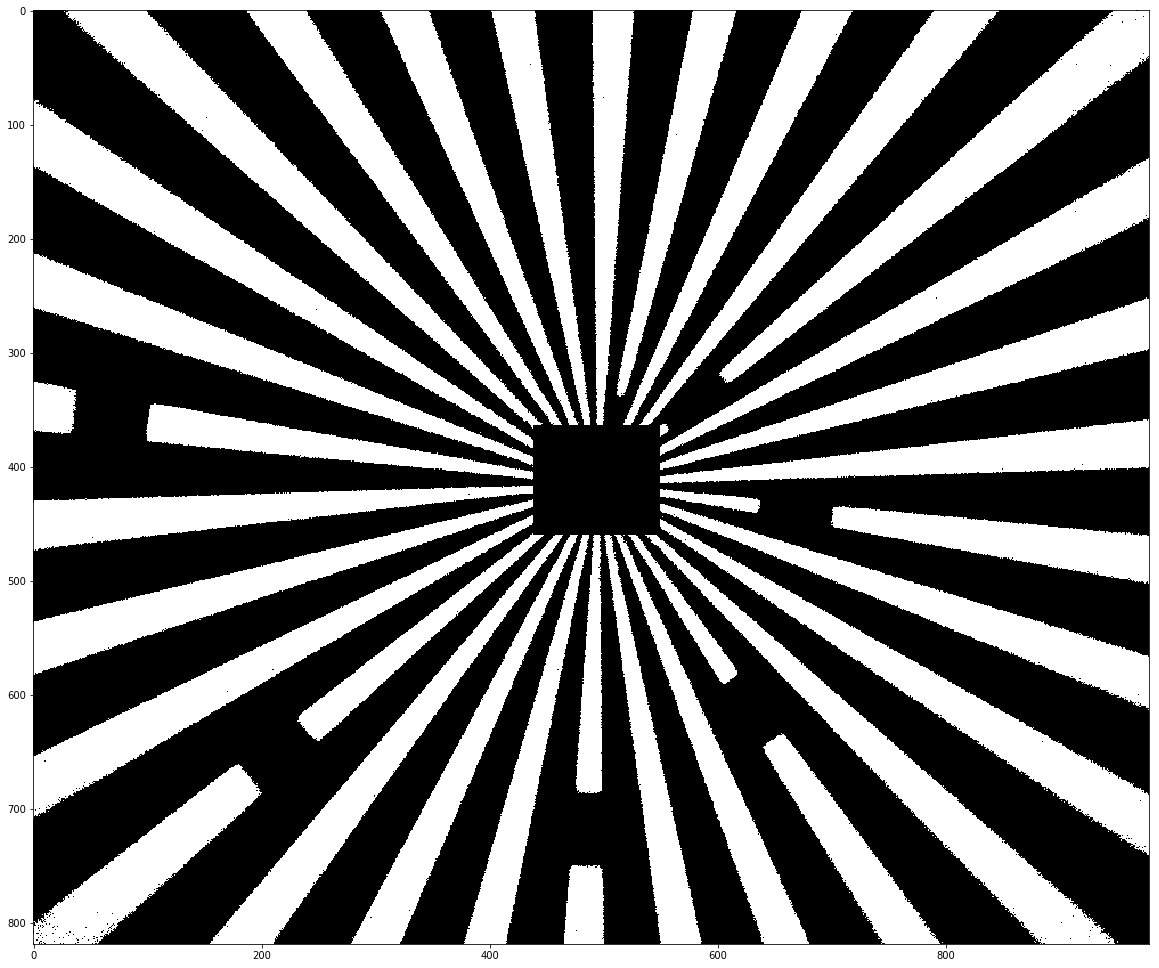

In [5]:
# Mask out center of image. 
h, w = img0_binary.shape
img0inv_masked = img0_binary_inv.copy()
mask = np.zeros_like(img0_binary, dtype=np.uint8)

vertices = np.array([[
                (w/2 - 50, h/2 - 45),
                (w/2 + 60, h/2 - 45), 
                (w/2 + 60, h/2 + 50), 
                (w/2 - 50, h/2 + 50)
            ]], 
                        dtype=np.int32)

cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(img0inv_masked, mask)
img0inv_masked[masked > 0] = 0

plt.figure(figsize=(20, 20))
plt.imshow(img0inv_masked, cmap='gray')
plt.show()



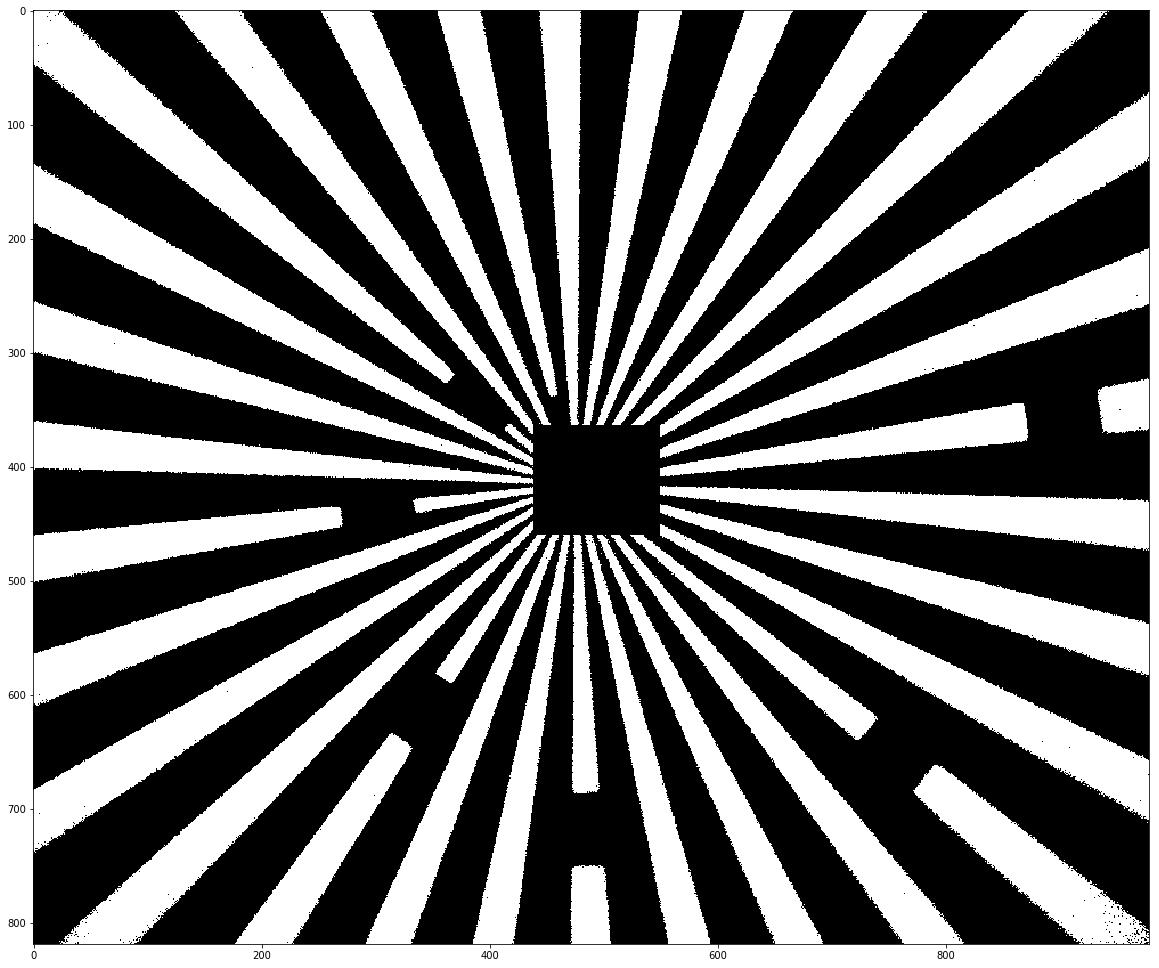

In [18]:
# Mask out center of image. 
h, w = img180_binary.shape
img180inv_masked = img180_binary_inv.copy()
mask = np.zeros_like(img180_binary, dtype=np.uint8)

vertices = np.array([[
                (w/2 - 50, h/2 - 45),
                (w/2 + 60, h/2 - 45), 
                (w/2 + 60, h/2 + 50), 
                (w/2 - 50, h/2 + 50)
            ]], 
                        dtype=np.int32)

cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(img180inv_masked, mask)
img180inv_masked[masked > 0] = 0

plt.figure(figsize=(20, 20))
plt.imshow(img180inv_masked, cmap='gray')
plt.show()



### Manual Labeling

To make sure that the errors in computing the cornor is not causing the Affine fittig to fail. For automatic point extraction : see the <a>./Morph_Contours</a> notebook.


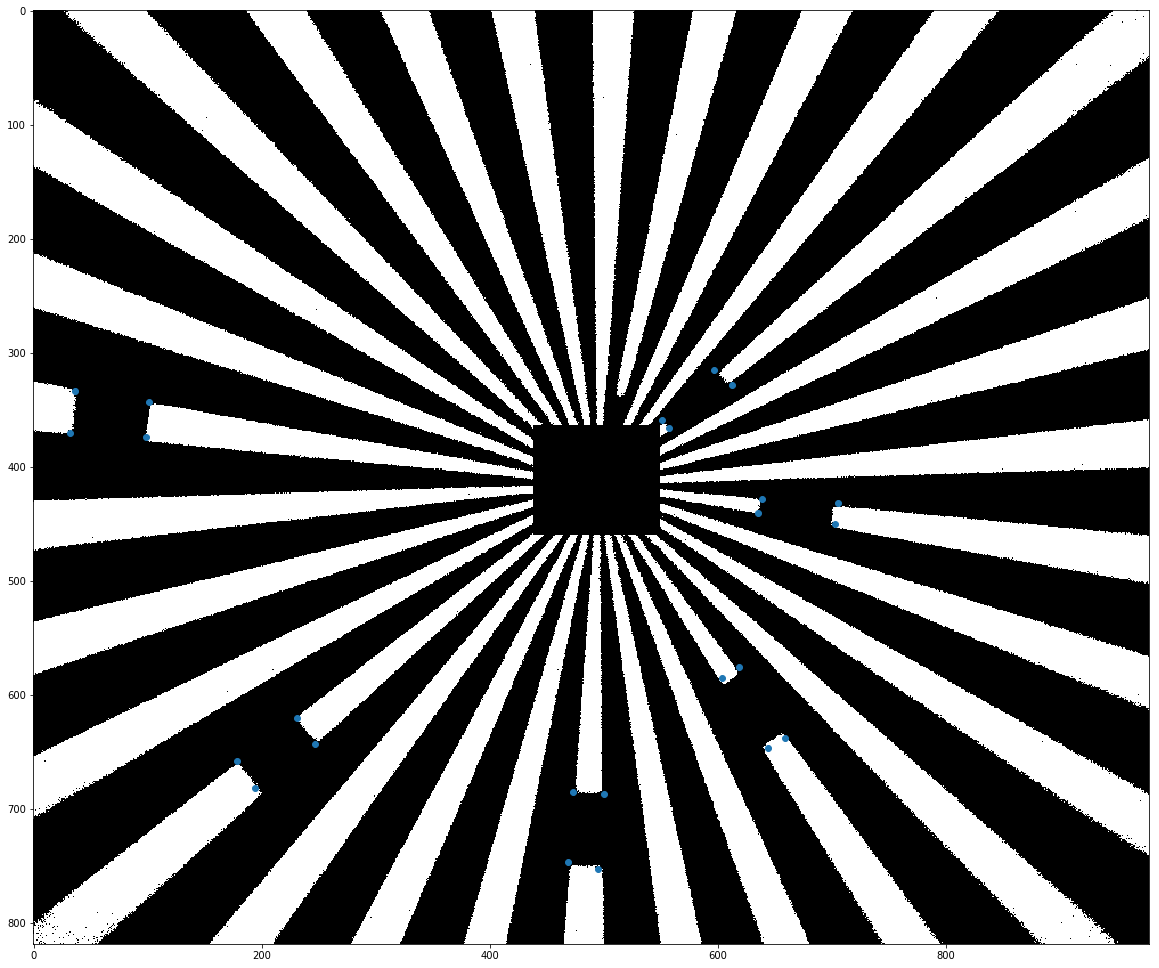

In [15]:
X_orig = [32,36,101,99,178,194,231,247,469,495,473,500,644,659,604,619,703,706,635,639,557,551,597,613]
Y_orig = [370,334,343,374,658,682,620,643,747,753,685,687,647,638,585,576,450,432,441,428,366,359,315,328]

plt.figure(figsize=(20, 20))
plt.imshow(img0inv_masked, cmap='gray')
plt.scatter(X_orig, Y_orig)
plt.show()

The automatic labeling is done in **Morph_Contours.ipynb** notebook. Here I am using the manual labeling of corners to make sure that final correspondance is as accurate as possible. Look at the pointPicker.py on how these points were picked. 

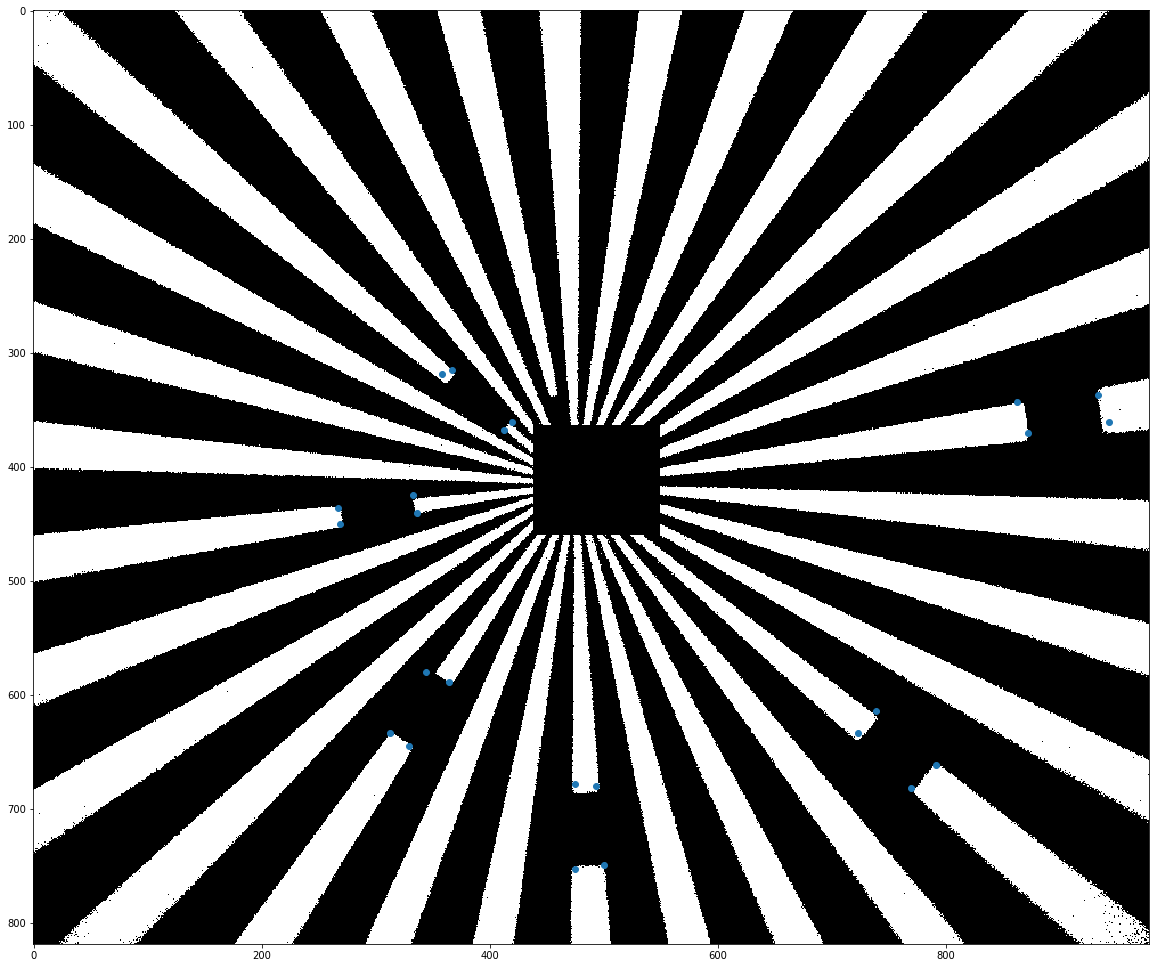

In [22]:
X_rot = [269,267,336,333,358,367,413,420,863,934,872,943,739,723,770,792,475,493,500,475,329,313,344,364]
Y_rot = [450,436,441,425,319,315,368,361,343,337,370,361,614,634,682,662,678,680,749,753,645,634,580,589]
plt.figure(figsize=(20, 20))
plt.imshow(img180inv_masked, cmap='gray')
plt.scatter(X_rot, Y_rot)
plt.show()

In [71]:
coord_orig = np.dstack((Y_orig, X_orig))
coord_rot = np.dstack((Y_rot, X_rot))

coord_orig = np.squeeze(coord_orig, axis=(0))
coord_rot = np.squeeze(coord_rot, axis=(0))

### Model

Apply the Affine fitting using the code from http://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html

(5.096015328936057, 0.450382650369444) [ -501.57252378 -1724.35799757] 67.15753204172806
(0.355798162645864, 0.3330579451309607) [ 269.71301942  321.97963364] 4.059346364799247


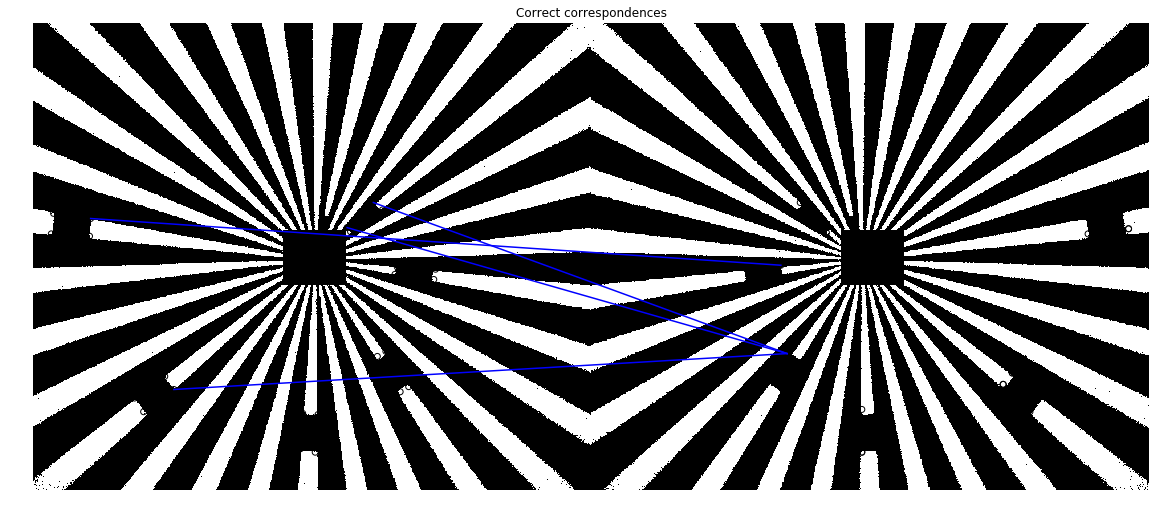

In [89]:
def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=8):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img0inv_masked[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 1)
    #print (weights.shape)
    #weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coord_rot:
        window_warped = img180inv_masked[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1]
        #print (window_warped.shape)
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coord_rot[min_idx]

#print (img180inv_masked.shape)

# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coord_orig:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
# print(tform.scale, tform.translation, tform.rotation)
print(model.scale, model.translation, model.rotation * 180.0/np.pi)
print(model_robust.scale, model_robust.translation, model_robust.rotation * 180.0/np.pi)

# visualize correspondence

plt.gray()
plt.figure(figsize=(20, 20))
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(plt, img0inv_masked, img180inv_masked, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
plt.axis('off')
plt.title('Correct correspondences')
plt.show()
# outlier_idxs = np.nonzero(outliers)[0]
# plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
#              np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
# ax[1].axis('off')
# ax[1].set_title('Faulty correspondences')

# plt.show()
